# Instalación y entrega

**Los datos necesarios para realizar la práctica están en una carpeta compartida que se llama `data`, situada en "Shared with me". Para que el cuaderno pueda acceder a ella es necesario crear un link en "My Drive". El link se crea simplemente seleccionando "data", y desde el menu del botón derecho seleccione "Add a shortcut to Drive".**

**Una vez hecho esto, ejecute la siguiente celda. Esta celda montará el directorio de trabajo del cuaderno y verá la carpeta `data` a través del link. Para montar el directorio le pedirá que se registre en "Drive"**.

**En las prácticas que requieren entrenar una red es importante cambiar el entorno de trabajo para trabajar con GPU. Para ello ir a Entorno de ejecución > Cambiar tipo de entorno de ejecución.**

**Cuando termine la práctica, rellenando las celdas de código y respondiendo a las preguntas, descárguelo a su máquina. Para bajar el cuaderno hay que ir a "Archivo --> Descargar --> Descargar .ipynb". Una vez descargado lo tenéis que subir a la actividad en formato ".ipynb".**

In [1]:
## Instalación: esta celda monta el directorio de trabajo
if 'google.colab' in str(get_ipython()):
    # Setup colab
    from google.colab import drive
    drive.mount('/drive')
    %cd /drive/My Drive/data
else:
    pass

Mounted at /drive
/drive/.shortcut-targets-by-id/1MHsiAeNCqIWHIkKgK7ggxOaSkemKqWSb/data


# Redes convolucionales I

En el tutorial se ha visto cómo construir un clasificador de imágenes uniendo una base preentrenada a una cabeza de clasificación formada por capas densas. La base que hemos utilizado es el modelo denominado **VGG16** y hemos visto, a través de las curvas de aprendizaje, que esta arquitectura tiende a sobreajustar el conjunto de datos (**overfitting**). Una de las estrategias más sencillas para reducir el **overfitting** consiste en utilizar una base más apropiada para el conjunto de datos. En esta ocasión vamos a usar una base preentrenada que se llama **InceptionV1** (también conocida como `GoogLeNet`). **InceptionV1** fué el ganador de la competición de clasificación de imágenes basada en **ImageNet**, [ILSVRC 2014](https://image-net.org/challenges/LSVRC/). Actualmente, su última versión es **InceptionV4**, y se encuentra entre las redes más competitivas en clasificación.

En primer lugar cargamos las librerías necesarias:

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import warnings
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as img
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

A continuación cargamos los mismos datos del tutorial, la base de datos `car_or_truck`:

In [3]:
# Reproducibility
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seed(31415)

# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'data_m3/datasets/car_or_truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    'data_m3/datasets/car_or_truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5117 files belonging to 2 classes.
Found 5061 files belonging to 2 classes.


El modelo **InceptionV1** preentrenado en **ImageNet** está disponible en el repositorio [TensorFlow Hub](https://www.tensorflow.org/hub/), aunque por rapidez, lo cargamos desde una copia local. Ejecuta esta celda para cargar **InceptionV1** en la base de la nueva red.

In [6]:
pretrained_base = tf.keras.models.load_model('data_m3/models/inceptionv1')

## Definición de la base preentrenada

Ahora que tenemos la base para hacer la extracción de características, decida si debe entrenar la base o no, mediante la opción `True` o `False`.

In [7]:
# EJERCICIO 1 --------- TO DO
pretrained_base.trainable = False

## Configuración de la cabeza

Tenemos una base entrenada para hacer extracción de características. Ahora creamos una cabeza de capas `Dense` para realizar la clasificación, siguiendo este diagrama:

<center>
<img src="https://i.imgur.com/i5VU7Ry.png" width="400" alt="">
<figcaption style="textalign: center; font-style: italic"><center>Diagrama de la configuración de la cabeza a partir de capas densas.
</center></figcaption></center>

In [8]:
# EJERCICIO 2 --------- TO DO
model =  keras.Sequential([
            pretrained_base,
            layers.Flatten(),
            layers.Dense(6, activation='relu'),
            layers.Dense(1, activation='sigmoid'),
])
model.build(input_shape=[None, 128, 128,3])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 1024)              5607184   
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 6)                 6150      
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 5,613,341
Trainable params: 6,157
Non-trainable params: 5,607,184
_________________________________________________________________


## Entrenamiento

Antes de entrenar un modelo, es necesario especificar el *optimizador* para realizar el descenso de gradiente, la función de pérdidas a minimizar (**loss**), y una métrica de rendimiento (**accuracy**). Como siempre, usaremos el optimizador ["Adam"](https://keras.io/api/optimizers/adam/), que generalmente tiene un buen rendimiento. Como hemos visto, la función de pérdidas y la métrica tienen que ser adecuados al tipo de problema que se está tratando de resolver. Nuestro problema es un **problema de clasificación binaria**: `Coche` codificado como 0, y `Camioneta` codificado como 1. Elija la función de pérdidas apropiada y una métrica de precisión apropiada para la clasificación binaria.

In [9]:
# EJERCICIO 3 --------- TO DO
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss= 'binary_crossentropy',
    metrics=['binary_accuracy']
)

El entrenamiento depende mucho del entorno de ejecución asignado por "Google Colaboratory", y puede durar aproximadamente 40 minutos. La celda ha sido comentada porque no es necesario completar el entrenamiento, más tarde mostraremos los resultados para que pueda analizarlos. **Para realizar el entrenamiento es importante cambiar el modo de ejecución de `Colab` para utilizar una `GPU`, en el menú `Entorno de ejecución`.** En la celda siguiente se realiza el entrenamiento. 

In [10]:

out = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=10,
    verbose=1,
)


Epoch 1/10
80/80 [==============================] - 790s 9s/step - loss: 0.7006 - binary_accuracy: 0.5419 - val_loss: 0.6892 - val_binary_accuracy: 0.6009
Epoch 2/10
80/80 [==============================] - 4s 54ms/step - loss: 0.6814 - binary_accuracy: 0.6490 - val_loss: 0.6632 - val_binary_accuracy: 0.7471
Epoch 3/10
80/80 [==============================] - 4s 54ms/step - loss: 0.6384 - binary_accuracy: 0.7340 - val_loss: 0.6063 - val_binary_accuracy: 0.7856
Epoch 4/10
80/80 [==============================] - 4s 53ms/step - loss: 0.5872 - binary_accuracy: 0.7799 - val_loss: 0.5633 - val_binary_accuracy: 0.8127
Epoch 5/10
80/80 [==============================] - 4s 53ms/step - loss: 0.5522 - binary_accuracy: 0.8013 - val_loss: 0.5349 - val_binary_accuracy: 0.8285
Epoch 6/10
80/80 [==============================] - 4s 53ms/step - loss: 0.5273 - binary_accuracy: 0.8165 - val_loss: 0.5127 - val_binary_accuracy: 0.8315
Epoch 7/10
80/80 [==============================] - 4s 55ms/step - los

Si ha realizado el entrenamiento, descomente y ejecute la celda siguiente para representar las curvas de pérdidas y las métricas.

Best Validation Loss: 0.4592
Best Validation Accuracy: 0.8417


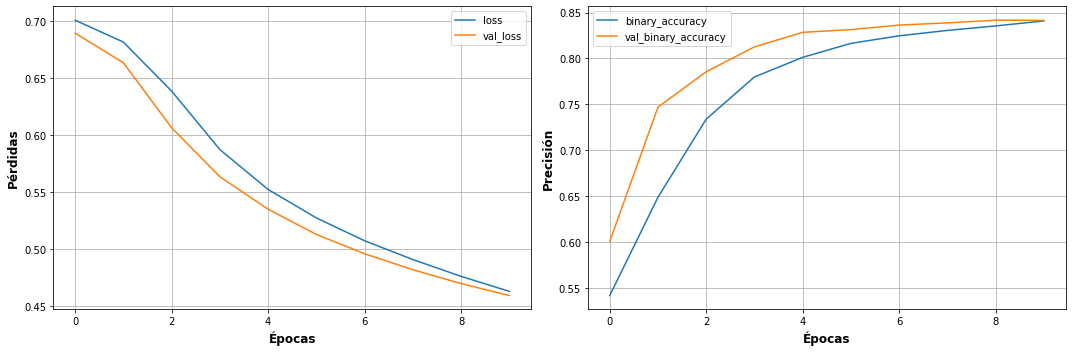

In [11]:

### Clasificador sobre la base de **InceptionV1**
history_df = pd.DataFrame(out.history)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 5))
history_df.loc[:, ['loss', 'val_loss']].plot(xlabel='Épocas', ax=ax1, grid=True)
ax1.set(xlabel='Épocas', ylabel='Pérdidas')
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(xlabel='Épocas',ax=ax2, grid=True);
ax2.set(xlabel='Épocas', ylabel='Precisión')
#plt.savefig('data/figs/training-inceptionv1.png')

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))


<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
    <strong>Nota:</strong><br>

Si no se ha realizado el entrenamiento, puede observar las gráficas de pérdidas descomentando y ejecutando el código de la siguiente celda.
</blockquote>

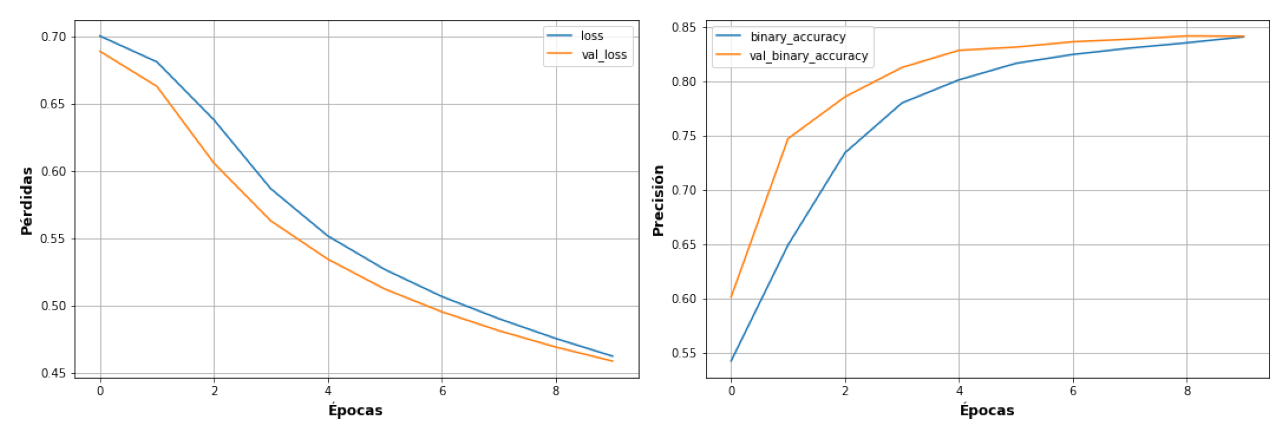

In [12]:
im = img.imread('data_m3/figs/training-inceptionv1.png')
plt.figure(figsize=(18, 10))
plt.imshow(im)
plt.axis("off");

Si ha realizado el entrenamiento, descomente y ejecute la celda siguiente para visualizar las predicciones sobre  el conjunto de validación.

2/2 [==============================] - 0s 23ms/step


FileNotFoundError: ignored

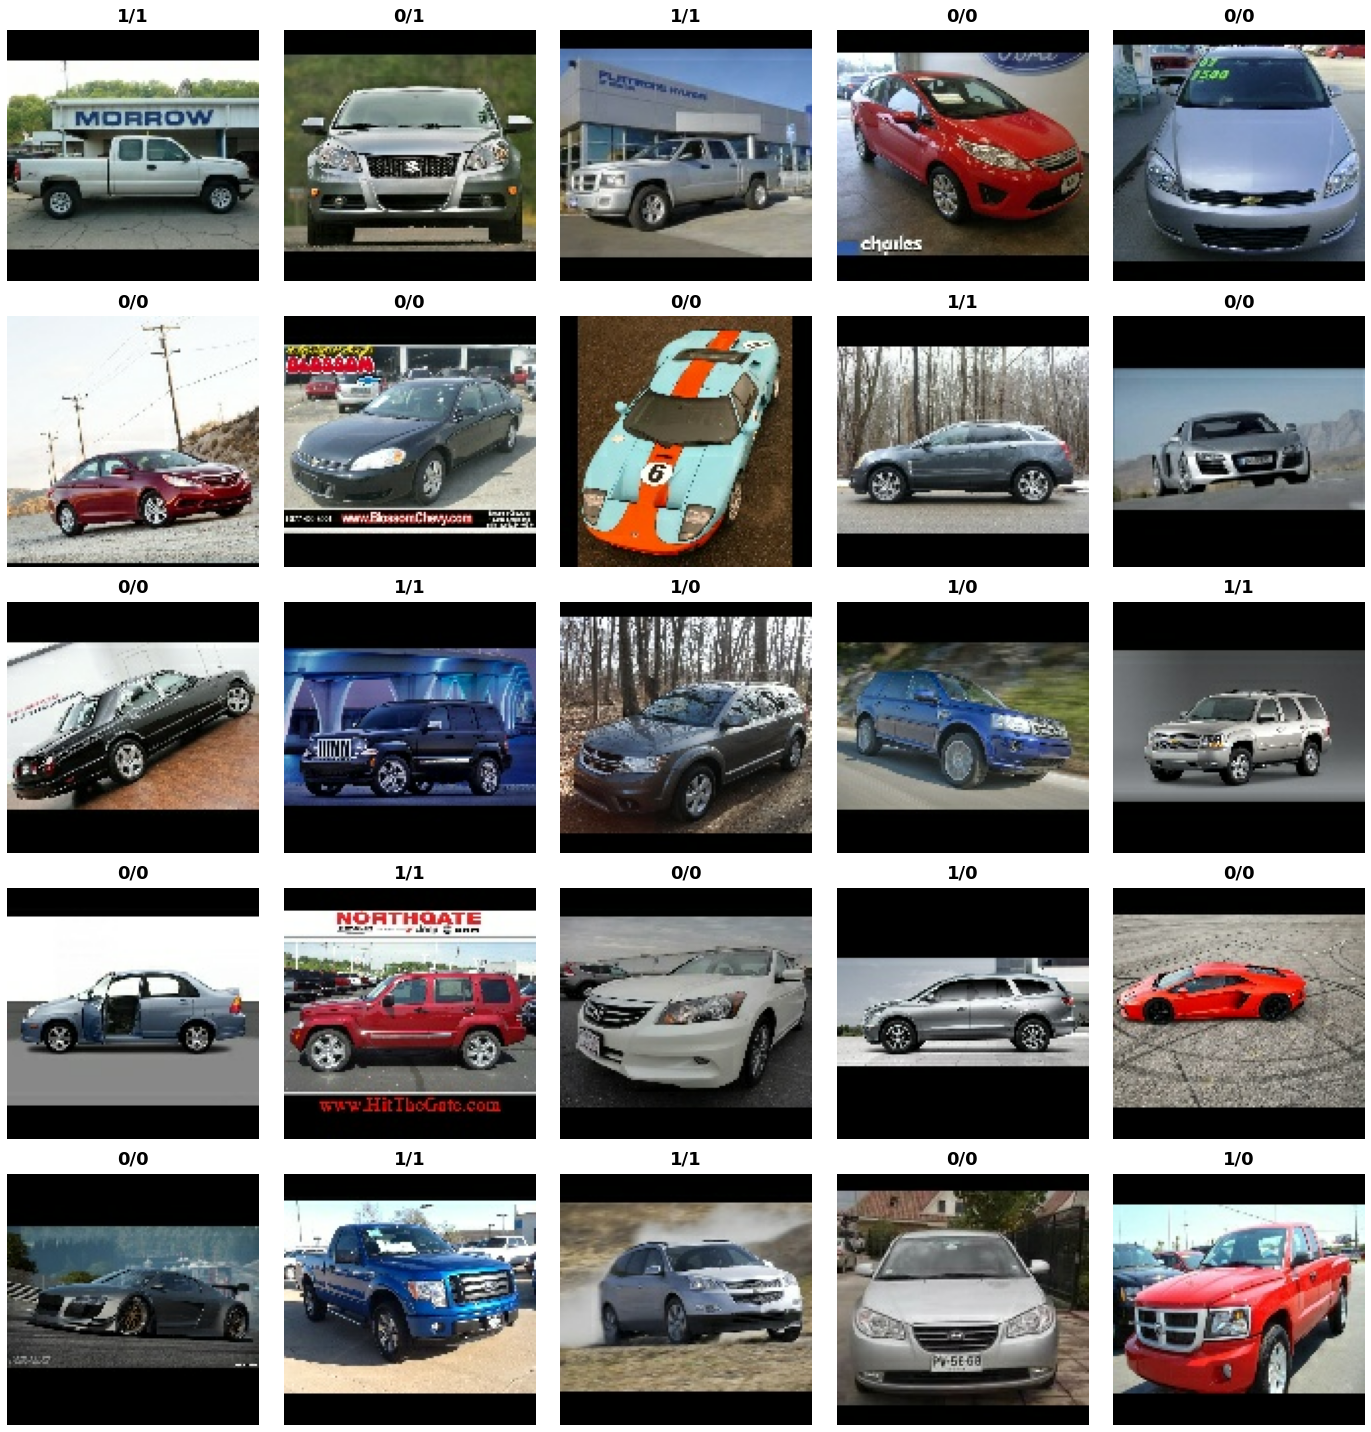

In [14]:

## Visualización de predicciones 
plt.figure(figsize=(20, 20))
for images, labels in ds_valid.take(1):  # only take first element of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

predictions = model.predict(numpy_images)
predictions = tf.where(predictions < 0.5, 0, 1)
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("float"))
    plt.title(str(labels[i].numpy().astype("int")[0]) + '/' + str(predictions[i].numpy()[0]))
    plt.axis("off")
plt.savefig('data/figs/training-inceptionv1-detection.png')


<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
    <strong>Nota:</strong><br>

Si no se ha realizado el entrenamiento, puede observar las predicciones sobre el conjunto de validación descomentando y ejecutando el código de la siguiente celda.
</blockquote>

In [ ]:
im = img.imread('data_m3/figs/training-inceptionv1-detection.png')
plt.figure(figsize=(22, 22))
plt.imshow(im)
plt.axis("off");

## Conclusiones

En esta práctica se han abordado los fundamentos de un **clasificador de imagen convolucional**, los cuales consisten en una **base** que extrae las características de las imágenes y una **cabeza** que utiliza las características para decidir la clase a la que pertenece la imagen. Hemos construido un clasificador sobre una base preentrenada usando el **aprendizaje por transferencia** (**Transfer learning**). 

# Preguntas

**La adquisición de las competencias asociadas a las prácticas requieren una explicación propia y rigurosa. Las copias y traducciones literales no demuestran la adquisición de las competencias, por tanto no se considerarán válidas (consultar la rúbrica).**

[texto del enlace](https://)<div class="alert alert-success">
1. ¿Qué es el "transfer learning"? ¿Cómo se utiliza en este caso? ¿Qué ventajas tiene respecto a entrenar una red desde cero?
</div>

%%%% TO DO %%%%%

**¿Qué es el "transfer learning"?**

El "transfer learning" es una técnica empleada para poder transferir los conocidmientos adquiridos por un modelo a otro. De esta forma, este nuevo modelo puede aprovechar la información recopilada por otro modelo y aplicarlo a su propio problema.

La potencia de esta técnica reside en que el problema del modelo al que le transferimos el conocimiento no tiene porqué ser el mismo que del modelo del que obtiene los datos, solo deben parecerse. Por lo que nos permite poder entrenar modelos con un número inferior de datos para ello.

Además, y lo que es más interesante, concede un ahorro significarivo en el conjutno de datos de entrenamiento necesarios. Ya que los modelos de los que se suele obtener la información han sido entrenados con grandes conjuntos de datos. Cosa que a su vez permite tener modelos muy pulidos.

**¿Cómo se utiliza en este caso?**

Existen dos posibles formas de aplicar el "transfer learning" a nuestro modelo.


1.   
Metodo 1: En este método, primero vamos a crear un modelo predictivo que se va a encargar de resolver un problema a partir de unos de entrada, su salida y ciertos conceptos relacionados entre sí. A continuación, desarrollamos un modelo diferente encargado de resolver la primera tarea. Llegados a este punto, es donde se da paso al"transfer learning", ya que este segundo modelo que hemos creado (denominado modelo fuente) va a utilizar la información aprendida por el primer modelo para resolver su propia tarea. Y, como ya he comentado antes, esta tarea que no tiene porqué ser la misma, solo debe parecerse. 
Tras todo esto, se optimiza y se corrigen posibles fallos que pueda tener el segundo modelo desarrollado. 
2.   Metodo 2: El otro método parte de la idea del anterior, solo que no nos tenemos que preocupar de desarrollar el modelo fuente, ya que vamos a utilizar uno que ya esté hecho. Todo lo demás es igual. 
De estos dos métodos,  el segundo es el que más extendido.

En base a esto, parece claro que estamos empleando el método 2, denominado Pre-trained aproach. Esto es así porque estamos cargando un modelo ya entrenado para aplicar la transferencia.

**¿Qué ventajas tiene respecto a entrenar una red desde cero?**

El uso del "transfer learning" nos proporciona diversas ventajas. De entrada, al estar partiendo de la información provista por un modelo ya entrenado, nuestro modelo no va a requerir tantos datos de entrada para poder entrenarse.
Esto no es poca cosa, ya que podemos partir de modelos entrenados durante mucho tiempo con bases de datos de millones de entradas.

Por otro lado, esta técnica agiliza mucho el entrenamiento de la red, permitiendonos gastar menos recursos en su entrenamiento. Esto lo he podido comprobar lanzando el modelo a entrenar. La diferencia es notable, tomandome unos 34 minutos en finalizar el proceso de aprendizaje haciendo uso de una Nvidia-Tesla 4.

<div class="alert alert-success">
2. ¿Qué es una "base preentrenada"? ¿Qué es la "cabeza" de la red? ¿Qué función tiene cada una de ellas?
</div>


%%%% TO DO %%%%%

**¿Qué es una "base preentrenada"?**

Se conoce como "base preentrenada" a un modelo ya entrenado para resolver un problema similar al que nosotros queremos tratar. 

Estas bases suelen ser muy importantes para el ya mencionado "transfer learning", ya que suelen haber sido entrenadas con un gran número de datos, y son modelos por lo general complejos.

De esta forma podemos generar modelos con un alto coste computacional, de forma que podamos entrenar a partir del "transfer learning" otros modelos diferentes.

**¿Qué es la "cabeza" de la red?**

La cabeza de la red es el modelo que va a obtener información a través del "transfer learning". Este modelo tipicamente es menos complejo y requiere de una base de datos con menores entradas gracias a la extracción de la información que hace a partir de la "base preentrenada"


<div class="alert alert-success">
3. Una vez definido el modelo en el ejercicio 2, ¿Cuántos parámetros entrenables tiene la red? Compárelas con los de la red **VGG16**.
</div>

%%%% TO DO %%%%%


Si descomentamos la linea model.Sumarry() de la celda del ejercicio 2. Nos devuelve lo siguiente:

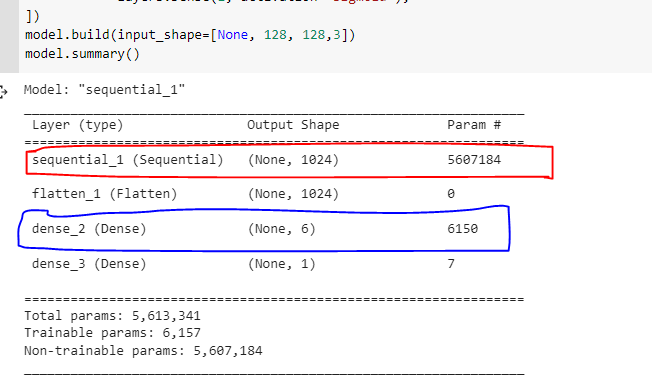

En esta imagen lo que podemos ver es información relativa a cada capa. Primero nos muestra el tipo de capa, luego su número de salidas, y finalmente la cantidad de parámetros que tiene.

Como la red que hemos creado está formada por una base preentrenada y una cabeza, tenemos información relativa a cada uno de estos dos elementos.

En rojo he señalado el número de parámetros entrenables de nuestra base preentrenada. Es un numero muy alto, pero era una cosa previsible ya que la gracia de emplear un modelo pre-entrenado es aprovecharnos de un modelo tan sofisticado como este.

En azúl, he marcado el número de entradas de nuestra cabeza. Que en este caso son 6150.

Sin embargo, el dato que andamos buscando está más abajo. Ya que en los 3 datos finales que nos devuelve el comando, vemos que nuestro modelo (base preentrenada + cabeza) posee un total de 6157 parámetros. Este valor es ligeramente superior a los parámetros que toma la cabeza, pero no es contraituitivo. Ya que estamos entrenando el conjunto de base preentrenada + cabeza.


<div class="alert alert-success">
4. A la vista de los resultados de la celda "### Clasificador sobre la base de **InceptionV1**". ¿Existe alguna diferencia entre estas curvas de aprendizaje y las curvas de aprendizaje del modelo **VGG16** mostrado en el tutorial? Razonar cómo ha sido el aprendizaje de cada modelo y los resultados. ¿Qué modelo es más adecuado para esta aplicación?
</div>

%%%% TO DO %%%%%

La mejor forma de comparar ambas gráficas, es primero estudiar cada una de ellas por separado.

# Gráfica del modelo InceptionV1

A partir de la gráfica de la izquierda, podemos estar completamente seguros de que lo que tenemos es un infraajuste del modelo. Esto se sostiene gracias a que la curva de pérdidas obtenida es inferior a la de pérdidas teórica, y no llegan a converger.
No obstante, parece que al final si que convergen, por lo que el rendimiento del modelo no parece descartable por el momento.

Es mas, si nos fijamos en la curva de la derecha, podemos comprobar que la precisión resultante (estamos tratando un problema de clasificación, por lo que la salida son probabilidades entre 0 y 1) es prácticamente igual que la teórica, sino la misma. 

Es decir, pese a que el modelo presente infraajuste durante varias épocas del proceso de entrenamiento, finalmente llega a establecer la configuración correcta de la red que permite la mayor precisión posible. Por lo que, como conclusión, las gráficas nos indican que el entrenamiento ha dado un resultado satisfactorio.

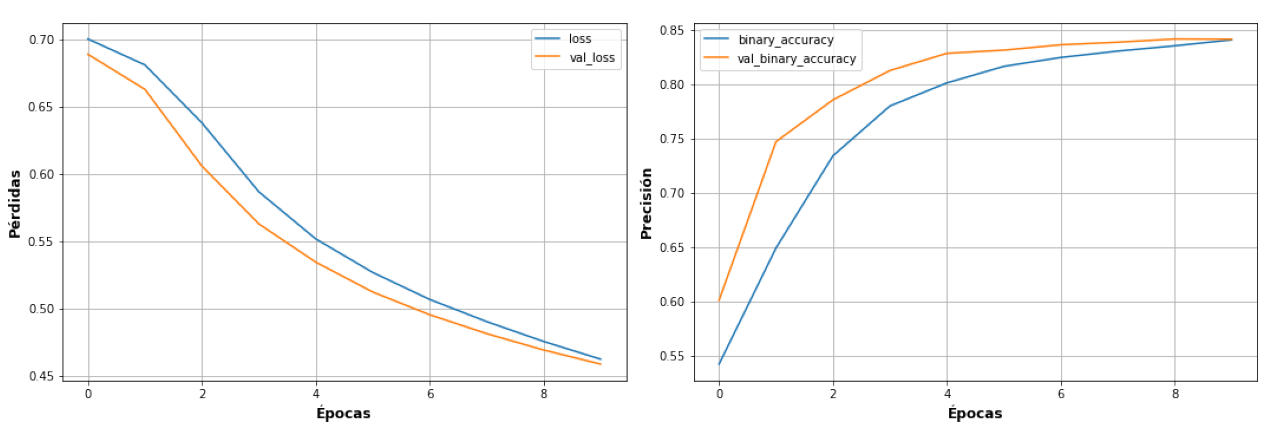


# Gráfica del modelo VGG16

Una vez hecho el estudio anterior, le toca el turno al modelo VGG16. De entrada, estas gráficas se diferencian con las anteriores en que se ha realizado un entrenamiento con 18 épocas en lugar de las 10 hechas en el modelo anterior.

Al igual que en el caso anterior, la grafica de la izquierda presenta un rendimiento del modelo que de entrada no es satisfactorio. Esto se debe a que  tenemos un sobreajuste notorio que podemos identificar gracias a la distancia de la curva de pérdidas teórica y medida. Este sobreajuste se debe de hecho al uso de capas convolucionales, cosa que se explica en la pregunta avanzada.

Con esto en mente, observando la gráfica de la derecha, es lógico que la precisión obtenida por el modelo sea inferior a la máxima teórica. Ya que da en torno a un 85% de certeza en la predicción, que no está mal, pero es inferior al teórico de algo más de 95%.

¿Esto hace descartable este modelo? Bueno, tiene sobreajuste, pero el resultado en la predicción es similar al caso anterior, por lo que de entrada podría valer. La verdadera enseñanza de esta segunda terna de gráficas es que el modelo puede presentar un mejor rendimiento. Esto lo podremos conseguir si logramos reducir el sobreajuste podremos acercarnos más a la seguridad del 95%.


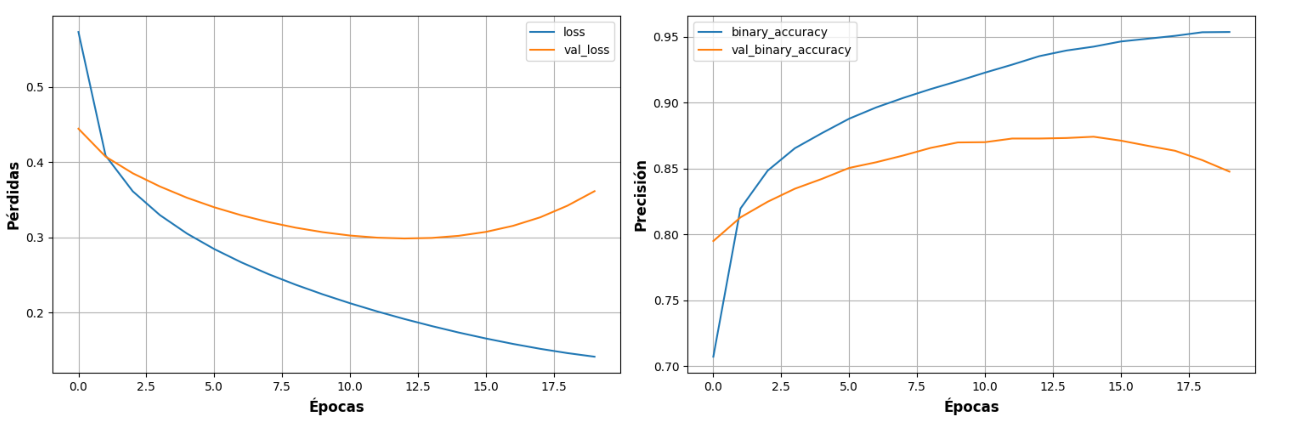

**Conclusión**

Pese a que ambos modelos presenten un rendimiento similar al tener probabilicades de certeza en la predicción similares, el modelo VGG16 podría hacer mejor el trabajo si logramos reducir su sobreajuste.

Esto presenta una reflexión curiosa, y es que las dos redes se han entrenado con la mísma "cabeza" y base de datos, pero han dado resultados diferentes. Es decir, la elección del modelo del cual obtenemos información es muy importante para poder adquirir un modelo que resuelva correctamente nuestro problema concreto. Por lo que no es tonteria probar con varios modelos ya entrenados para poder seleccionar el que mejor rendimiento proporcione a nuestra tarea. 

<div class="alert alert-success">
5. En la celda "## Visualización de predicciones", correspondiente al conjunto de validación. ¿Qué significa el título de cada gráfica?. Este problema de clasificación es complicado, considere algunos casos donde la red no ha acertado y comente las razones por las que cree que esto ha ocurrido.
</div>

%%%% TO DO %%%%%

<div class="alert alert-danger">
Pregunta avanzada:

    Busque información sobre los modelos **VGG16** e **Inception** y explique brevemente sus características. 
</div>

%%%% TO DO %%%%% 

**VGG16**

VGG16 es una red neuronal convolucional bastante popular por lograr alcanzar una clasificación correcta del 92.7% en Imaginet. Siendo uno de los porcentajes más altos que se han logrado obtener.

Este hito se obtuvo gracias a proponer una dimensión de la convolución de 3x3, mientras que usualmente se hacian de tamaño 5x5 u 11x11. Este cambio, pese a que diese buenos resultados, hizo que el entrenamiento fuese más árduo. Esto se debe a que la base de datos usada en Imagenet es de unas 14 millones de imágenes, por lo que el modelo se entrenó durante semanas.

Si pasamos a las "tripas" del modelo, VGG16 presenta un total de 22 capas. De las cuales 13 son capas convolucionales con función de activación "ReLu", 5 son capaz del tipo "max pooling", 3 son capas densas con función de activación "Relu", y una (la capa final), es del tipo "softmax".

La disposición de las capas es la siguiente:

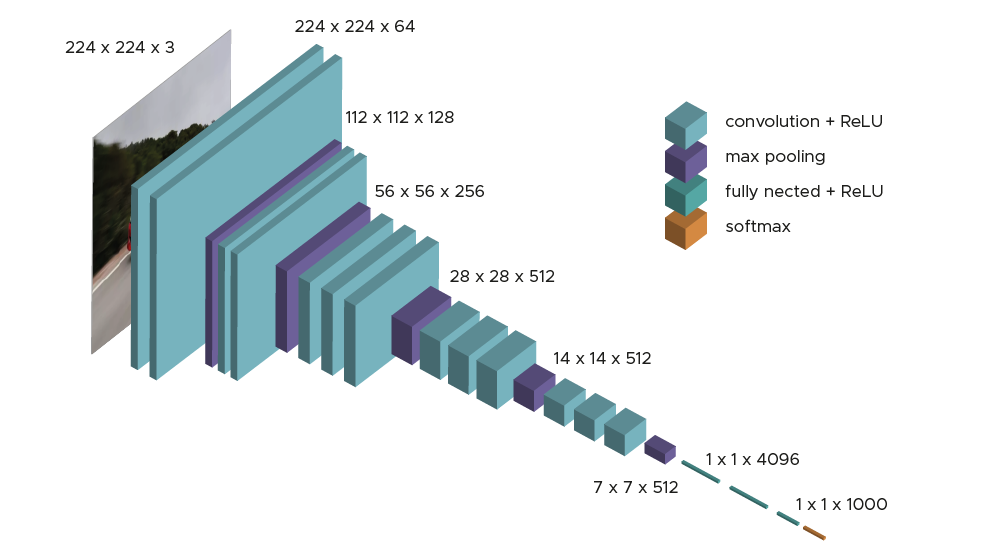


La red toma como entrada imágenes RGB de tamaño 224x224. Estas imágenes irán pasando por capas de convolución, que todas aplican la convolución de tamaño 3x3. 

Tras las convoluciones, tal y como se ve en las capas moradas de la imagen anterior, hay capas del tipo "max pooling". Estas capas tienen como misión reducir el tamaño de los filtros durante el proceso de entrenamiento.

Tras los procesos de convolución y filtrado, al final, hay 3 capas densas. Las dos primeras son de 4096 neuronas y función de activación "ReLu", mientras que la última es de 1000 y usa una función de activación "SoftMax".

El hecho de que su topología sea fácil de entender, hizo de este modelo muy popular. De hecho, tal y como hemos visto en la práctica, es uno de los favoritos para a provechar el "Transfer Learning". Ya que los recursos de que disponian para el entrenamiento eran titanicos, y no cualquiera tiene acceso a ellos.


**Inception**

El modelo inception se creó para resolver un problema latente en el uso de varias capas convoluciónales, el sobreajuste que se producía. Por lo que, para solucionar esto, se planteó el uso de este modelo, que planteaba el uso de diversos filtros de distinto tamaño en el mismo nivel.

Es decir, el modelo no crece en longitud, sino en anchura, añadiendo más capas en paralelo. Esto se entiende mejor en la siguiente captura de la topología del inception V1, en la cual vemos que entre dos capas tenemos varias en paralelo.

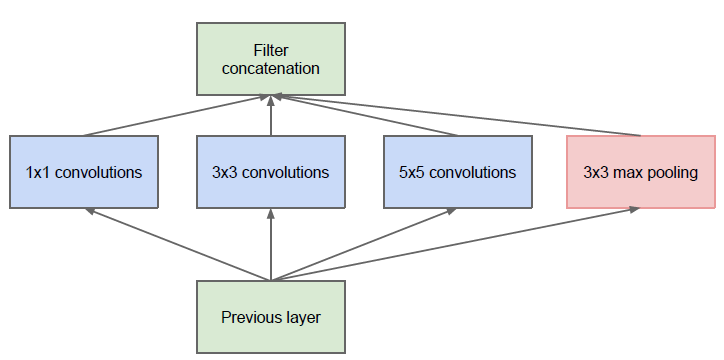

Sin embargo, esto consume mucho tiempo y carga computacional. No loso por tener varias capas en paralelo, sino porque cada capa es individualmente muy costosa. Como pasa por ejemplo con la convolución de tamaño 5x5, que requiere de mucho coste computacional.

Sin embargo, los creadores lograron encontrar una solución a esto, y esque descubrieron que podían agilizar el modelo añadiendo capas convolucionales 1x1. Esto se ve mejor en la siguiente imagen.

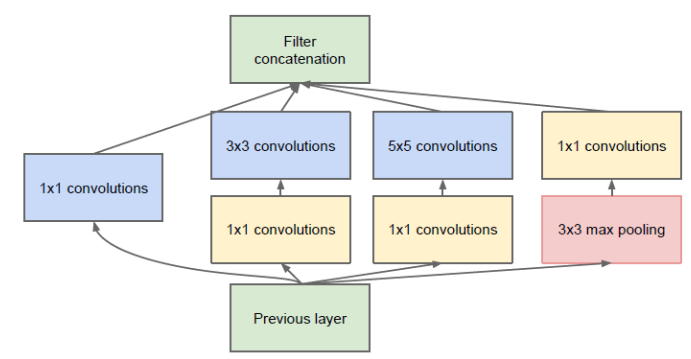

Esta de hecho es la topología del modelo Inception V1. Hoy en día se trabaja con la versión V3, que presenta convoluciones de valor aún mas pequeña, clasificadores auxiliares y una reducción en el tamaño de la red.

Estas factorizaciones tan pequeñas se lograron concatenando varias capas seguidas, tal y como se ve en el recuadro rojo de la siguiente imagen.


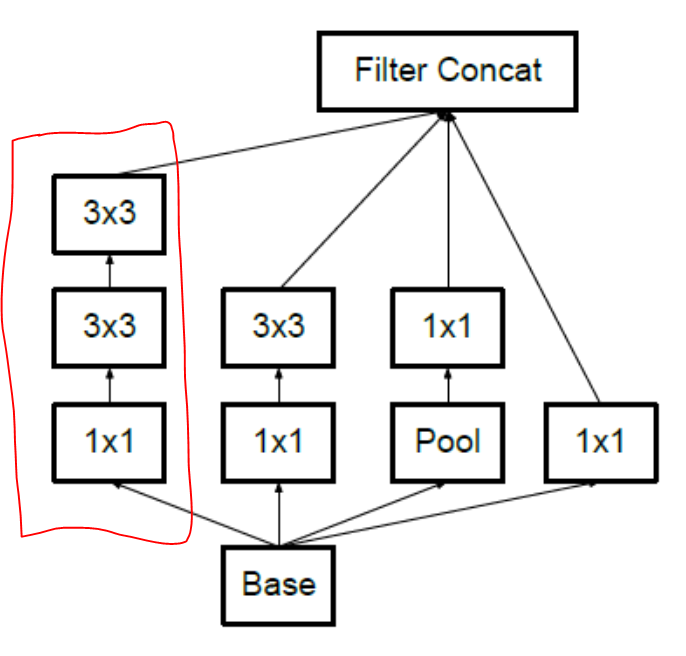

Esto significa una reducción de los parámetros con los que se trabaja, agrupandolos cada vez más. La siguiente imagen ilustra esto de manera visual, donde cada cuadradito es un parámetro.

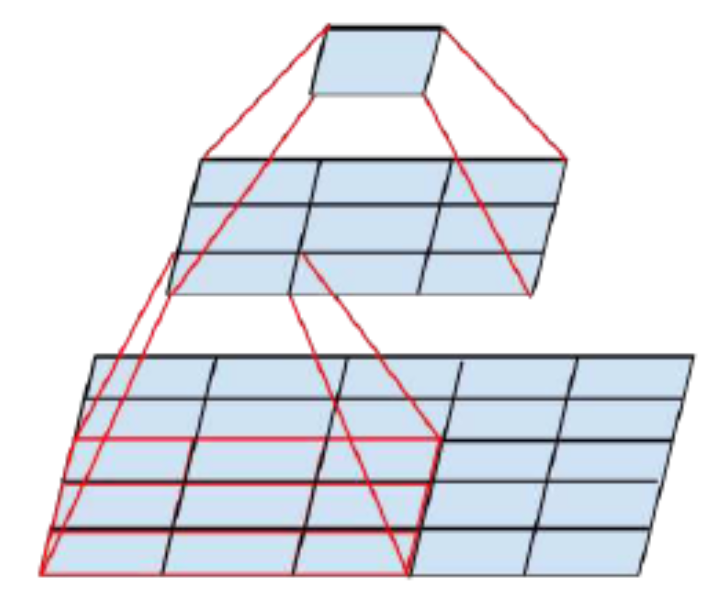